In [147]:
%matplotlib inline

from utils import Bootstrap
from collections import defaultdict
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import jit, grad, lax, random, value_and_grad, vmap
from jax.example_libraries import stax, optimizers
import flax.linen as nn
import optax
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
import logging 
import tqdm
logging.basicConfig(level = logging.INFO)
logger = logging.getLogger('Autoencoder')
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
data = datasets.load_digits()
data = datasets.load_iris()

X = data.data
y = data.target
target_names = data.target_names.astype(str)
N_DIM = 2
LEARNING_RATE = 0.01
BATCH_SIZE = 60
input_dim = X.shape[1]
X = MinMaxScaler().fit_transform(X)
X.shape

(150, 4)

In [148]:
def plot_dim_reduction(ax, predicted, target, title='', pca=False):
    dim_reduced = pd.DataFrame(predicted, columns=['Dim 1','Dim 2']) \
        .assign(target = target)  \
        .assign(target = lambda d: d.target.map(dict(zip(set(y),target_names))))

    sns.scatterplot(data=dim_reduced, x= 'Dim 1', y ='Dim 2',hue ='target', ax=ax)
    ax.set_title(title, size=15)
    if pca:
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')

In [149]:
plt.imshow(X[0].reshape(8,8))

ValueError: cannot reshape array of size 4 into shape (8,8)

# FLAX model #

In [150]:
class Autoencoder(nn.Module):

    def setup(self):
        self.encoder = nn.Sequential(
            [
                nn.Dense(N_DIM), 
                nn.sigmoid
            ]
        )
        
        self.decoder = nn.Sequential(
            [
                nn.Dense(input_dim),
                nn.sigmoid
            ]
        )

    def __call__(self, x):
        h = self.encoder(x)
        return self.decoder(x)
    
    def encode(self, x):
        return self.encoder(x)

100%|██████████| 1500/1500 [00:07<00:00, 187.79it/s]


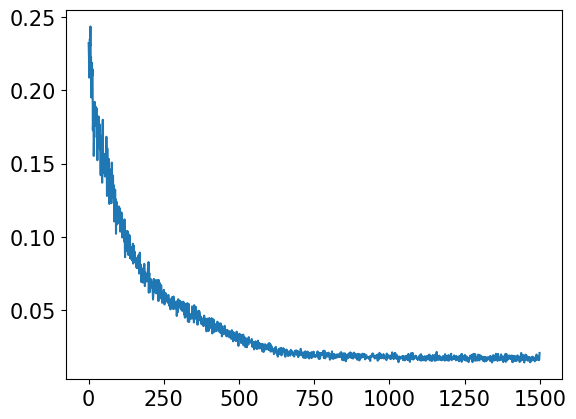

In [151]:
model = Autoencoder()
epoch = 1500
LEARNING_RATE=0.01
minibatches = bootstrap.bootstrap(X, group_size = BATCH_SIZE, n_boots = epoch+1)
optimizer = optax.adam(learning_rate=LEARNING_RATE)
key1, key2 = random.split(random.PRNGKey(0))
params = model.init(key2, X[next(minibatches)]) # Initialization call
opt_state = optimizer.init(params)


@jit
def forward_loss(params, x):
    y = model.apply(params, x)
    return jnp.mean(jnp.abs(y - x))

losses = np.zeros(epoch)
bootstrap = Bootstrap()
for i in tqdm.tqdm(range(epoch)):
    minibatch = X[next(minibatches)]
    loss, grads = value_and_grad(forward_loss)(params, minibatch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    losses[i] = loss
    if (i+1) % (epoch//5) == 0:
        logger.info('%i iteration: RMSE = %.2f' %(i+1, loss))
plt.plot(losses)

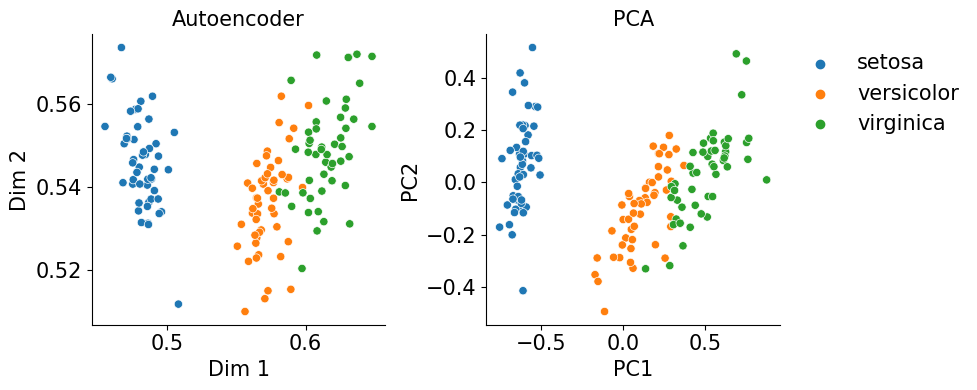

In [152]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
vae = model.apply(params, X, method=model.encode)
plot_dim_reduction(ax, vae, y, title='Autoencoder', pca=False)
ax.legend().set_visible(False)
pca = PCA(n_components=2).fit_transform(X)
ax = fig.add_subplot(122)
plot_dim_reduction(ax, pca, y, title = 'PCA', pca=True)
fig.tight_layout()
ax.legend(fontsize=15, title='', bbox_to_anchor=(1,1), frameon=False)
sns.despine()

In [154]:
from sklearn.svm import SVC
vae_model = SVC(kernel="linear")
vae_model.fit(vae, y)

pca_model = SVC(kernel="linear")
pca_model.fit(pca, y)
print('Logit for VAE: %.3f vs Logit for PCA: %.3f' %(vae_model.score(vae,y), pca_model.score(pca,y)))

Logit for VAE: 0.940 vs Logit for PCA: 0.967


## Stax

In [49]:
encoder_init, encode = stax.serial(
    stax.Dense(5), stax.Relu,
    stax.Dense(ndim), stax.Sigmoid
)

decoder_init, decode = stax.serial(
    stax.Dense(5), stax.Relu,
    stax.Dense(X.shape[1]), stax.Sigmoid,
)

In [12]:
rng = random.PRNGKey(1)  # fixed prng key for evaluation
encode_rng, decode_rng = random.split(rng)

In [13]:
@jit
def loss(predicted, Y):
    #mse function
    return jnp.mean( (Y - predicted)**2 )

@jit
def VAE(params, x):
    encoded = jit(encode)(params['encoder'], x)
    decoding = jit(decode)(params['decoder'], encoded)
    return loss(decoding, x)

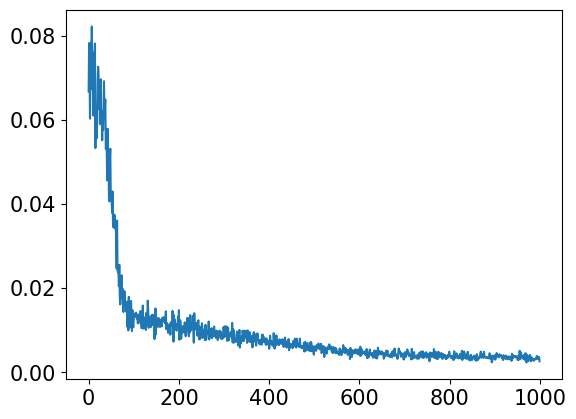

In [14]:
epoch = 1000
losses = np.zeros(epoch)
params = {}
_, params['encoder'] = encoder_init(encode_rng, (batch_size, X.shape[1]))
_, params['decoder'] = decoder_init(decode_rng, (batch_size, ndim))
opt_init, opt_update, get_params = optimizers.adam(step_size = lr)
opt_state = opt_init(params)
bootstrap = Bootstrap()
minibatches = bootstrap.bootstrap(X, group_size = batch_size, n_boots = epoch)

for i in range(epoch):
    minibatch = X[next(minibatches)]
    rmse, gradients = value_and_grad(VAE)(get_params(opt_state), minibatch)
    losses[i] = rmse.mean()
    opt_state = opt_update(i, gradients, opt_state)
    if (i+1) % (epoch//5) == 0:
        logger.info('%i iteration: RMSE = %.2f' %(i+1, rmse))
plt.plot(losses)

KeyError: 'encoder'

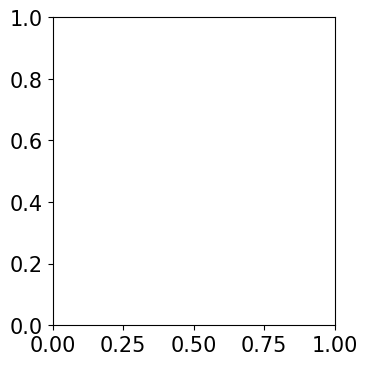

In [76]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(121)
vae = encode(params['encoder'], X)
plot_dim_reduction(ax, vae, y, title='Autoencoder', pca=False)
ax.legend().set_visible(False)
pca = PCA(n_components=2).fit_transform(X)
ax = fig.add_subplot(122)
plot_dim_reduction(ax, pca, y, title = 'PCA', pca=True)
fig.tight_layout()
ax.legend(fontsize=15, title='', bbox_to_anchor=(1,1), frameon=False)
sns.despine()

In [75]:
from sklearn.svm import SVC
vae_model = SVC()
vae_model.fit(vae, y)

pca_model = SVC()
pca_model.fit(pca, y)
print('Logit for VAE: %.3f vs Logit for PCA: %.3f' %(vae_model.score(vae,y), pca_model.score(pca,y)))

Logit for VAE: 0.953 vs Logit for PCA: 0.960
